In [1]:
import torch
nn = torch.nn
import torch.nn.functional as F
import numpy as np

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('Is dictionary category_lines successfully created:')
print(category_lines['Italian'][:5])

#######################################################

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

############ data processing ###########################

category_to_index = {}
for i in range(n_categories):
  lang = all_categories[i]
  category_to_index[lang] = i

name_list = []
index_list = []
for lang in category_lines:
  name_list = name_list + category_lines[lang]
  n = len(category_lines[lang])
  ind = category_to_index[lang]
  index_list = index_list + [ind]*n
  
assert len(name_list) == len(index_list)
n_data = len(name_list)

data_ind = np.arange(n_data)
np.random.shuffle(data_ind)
train_ind, valid_ind, test_ind = np.split(data_ind, [int(.8*n_data), int(.9*n_data)])
n_train = len(train_ind)
n_valid = len(valid_ind)

print('n_train:')
print(n_train)
print('check if train_ind looks right:')
print(train_ind[:30])

Is dictionary category_lines successfully created:
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
n_train:
16059
check if train_ind looks right:
[ 2779 18064  3689  7826  6793   214  2415 18680  4663  9394  8171  2944
  7633  5414 13335  7119 14843  3134 20019  5731 16695 12150  4351  6220
 12443 11136 14037  6631  4224  3809]


In [2]:
#device = torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
HIDDEN_SIZE = 128
n_stack = 2
n_batch = 32
lr = 1e-3
h0 = torch.zeros((n_stack, HIDDEN_SIZE), device=device)
c0 = torch.zeros((n_stack, HIDDEN_SIZE), device=device)
block = nn.LSTM(input_size=n_letters, hidden_size=HIDDEN_SIZE, num_layers=n_stack, device=device)
decoder_input_size = (torch.flatten(torch.cat((h0, c0)))).size()[0]
decoder = nn.Linear(decoder_input_size, n_categories, device=device)
#softmax_layer = nn.Softmax()


In [31]:
class My_RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_stack=2):
    super(My_RNN, self).__init__()
    self.hidden_size = hidden_size
    self.h0 = torch.zeros((n_stack, hidden_size))
    self.c0 = torch.zeros((n_stack, hidden_size))
    self.block = nn.LSTM(input_size, hidden_size, num_layers=n_stack)
    self.decoder_input_size = (torch.flatten(torch.cat((h0, c0)))).size()[0]
    self.decoder = nn.Linear(decoder_input_size, output_size)

  def forward(self, inp, hidden):
    # hidden: (h, c)
    return block(inp, hidden) # out, (h, c)

  def get_output(self, final_hidden):
    out = torch.cat(final_hidden)
    out = torch.flatten(out)
    out = decoder(out)
    return out

  def getInitHidden(self):
    return (self.h0, self.c0)

HIDDEN_SIZE = 128
n_batch = 32
lr = 1e-3
rnn = My_RNN(n_letters, HIDDEN_SIZE, n_categories).to(device)

In [12]:
a = torch.tensor(3)
b = torch.tensor(4)
c = torch.tensor(5)
d, h = a, (b,c)
h

(tensor(4), tensor(5))

In [21]:
for name, p in rnn.named_parameters():
  print(f'{name}')

block.weight_ih_l0
block.weight_hh_l0
block.bias_ih_l0
block.bias_hh_l0
block.weight_ih_l1
block.weight_hh_l1
block.bias_ih_l1
block.bias_hh_l1
decoder.weight
decoder.bias


In [25]:
def train(name, true_index):
  # modifies parameters of the model after the model sees *only one* data point.
  # name: tensor
  # e.g. name = lineToTensor('Jones'), whose shape is [5, 1, n_letters]
  # true_index: tensor of an integer

  name_len = name.size()[0]
  h = h0
  c = c0

  for i in range(name_len):
    input_letter = name[i]
    # input_letter must have shape [1, input_size of block]
    _, (h, c) = block(input_letter, (h, c))

  out = torch.cat((h, c))
  out = torch.flatten(out)
  out = decoder(out)
  loss = F.cross_entropy(out, true_index)

  loss.backward()

  with torch.no_grad():
      for p in block.parameters():
          p -= p.grad * lr / n_batch
      for p in decoder.parameters():
          p -= p.grad * lr / n_batch

      block.zero_grad()
      decoder.zero_grad()

  return out, loss.item()

def evaluate(name):
  # name: tensor
  # e.g. name = lineToTensor('Jones'), whose shape is [5, 1, n_letters]

  name_len = name.size()[0]
  h = h0
  c = c0

  with torch.inference_mode():
    for i in range(name_len):
      input_letter = name[i]
      # input_letter must have shape [1, input_size of block]
      _, (h, c) = block(input_letter, (h, c))

    out = torch.cat((h, c))
    out = torch.flatten(out)
    out = decoder(out)

  return out

def get_val_loss():
  # randomly selects n_batch validation samples and calculate average loss
  loss_sum = 0
  arr = np.random.choice(n_valid, n_batch)
  for j in arr:
    ind = valid_ind[j]
    name_tensor = lineToTensor(name_list[ind]).to(device)
    true_index = torch.tensor(index_list[ind], device=device)

    loss = F.cross_entropy(evaluate(name_tensor), true_index)
    loss_sum += loss.item()

  return loss_sum / n_batch


In [38]:
epochs = 50
n_iters = epochs*n_train
print_every = 1000
loss_sum = 0
avg_loss_list = []

for iter in range(1, n_iters+1):
  ind = train_ind[(iter-1) % n_train]
  name_tensor = lineToTensor(name_list[ind]).to(device)
  true_index = torch.tensor(index_list[ind], device=device)

  _, loss = train(name_tensor, true_index)
  loss_sum += loss

  if iter % print_every == 0:
    avg_loss = loss_sum / print_every
    #mem = torch.cuda.memory_allocated(device)/1024**2 # MB
    print(f'iter: {iter} | loss: {avg_loss} | val_loss: {get_val_loss()}')
    avg_loss_list.append(avg_loss)
    loss_sum = 0

  # shuffle training data every epoch
  if iter % n_train == 0:
    np.random.shuffle(train_ind)

TypeError: ignored

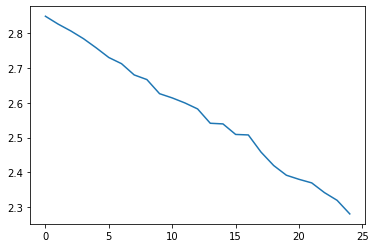

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(avg_loss_list)